# COMUNICACION DE RESULTADOS

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

#Automcompletar rápido
%config IPCompleter.greedy=True

pd.options.display.max_columns = None

con = sa.create_engine('sqlite:///../Datos/airbnb.db')

df = pd.read_sql('df_preparado', con = con)

#Minicubo precio:

metricas = ['precio_total','precio_compra']
dimensiones = ['bedrooms_disc','accommodates_disc','beds_disc']

minicubo_precio = df[dimensiones + metricas]

minicubo_precio = minicubo_precio.melt(id_vars=['precio_total','precio_compra'])

minicubo_precio = minicubo_precio.groupby(['variable','value'])[['precio_total','precio_compra']].agg('median')

#Minicubo ocupación

metricas = ['ocupacion']
dimensiones = ['bedrooms_disc', 'accommodates_disc','beds_disc']

minicubo_ocupacion = df[dimensiones + metricas]

minicubo_ocupacion = minicubo_ocupacion.melt(id_vars=['ocupacion'])

minicubo_ocupacion = minicubo_ocupacion.groupby(['variable','value'])[['ocupacion']].agg('mean')

## CONTEXTO DEL ANÁLISIS

La empresa ha seleccionado la Ciudad de México como candidata para buscar inmuebles en los que invertir con el objetivo de obtener rentabilidad mediante alquiler turístico.

Para ello, antes de poner al equipo de valoraciones a buscar oportunidades, la dirección ha encargado al equipo de Data Science un análisis de Discovery que permita identificar estrategias o líneas de trabajo que ayuden a dirigir la actuación del equipo de valoraciones.

## OBJETIVOS

* Analizar las fuentes de datos públicas disponibles.
* Encontrar insights que ayuden a entender las características del mercado en esta ciudad.
* Y guíen el trabajo de búsqueda del equipo de valoraciones.
* Especialmente en cuanto a los principales ejes: precio del alquiler, niveles de ocupación y precio de compra.

## CONCLUSIONES EJECUTIVAS

* Se han localizado 5 alcaldías en los que centrar la búsqueda
* Se recomienda buscar inmuebles de 0 habitaciones, 0 a 2 camas y que permitan alojar hasta 3 huéspedes
* Se recomienda buscar inmuebles que estando en una de las 5 alcaldías identificadas no estén necesariamente cerca de puntos de interés

## DETALLE DE LOS PRINCIPALES RESULTADOS

### Existen 5 alcaldías con alto potencial de inversión

* Se han localizado 5 alcaldías que apriori pueden maximizar la relación coste-ingresos
* Podemos segmentarlos por el tipo calidad del inmueble en el que nos interesa invertir en 3 grupos
* Además se ha tomado en cuenta la percepción de inseguridad de cada alcaldía (Percepción de inseguridad Diciembre 2023)
* Estas son las 5 alcaldías donde comenzar a buscar oportunidades concretas:
    * Inversión media: Tlalpan, La Magdalena Contreras
    * Inversión media-alta: Benito Juárez, Cuajimalpa de Morelos
    * Inversión alta: Miguel Hidalgo

Exhibit 1.4.1

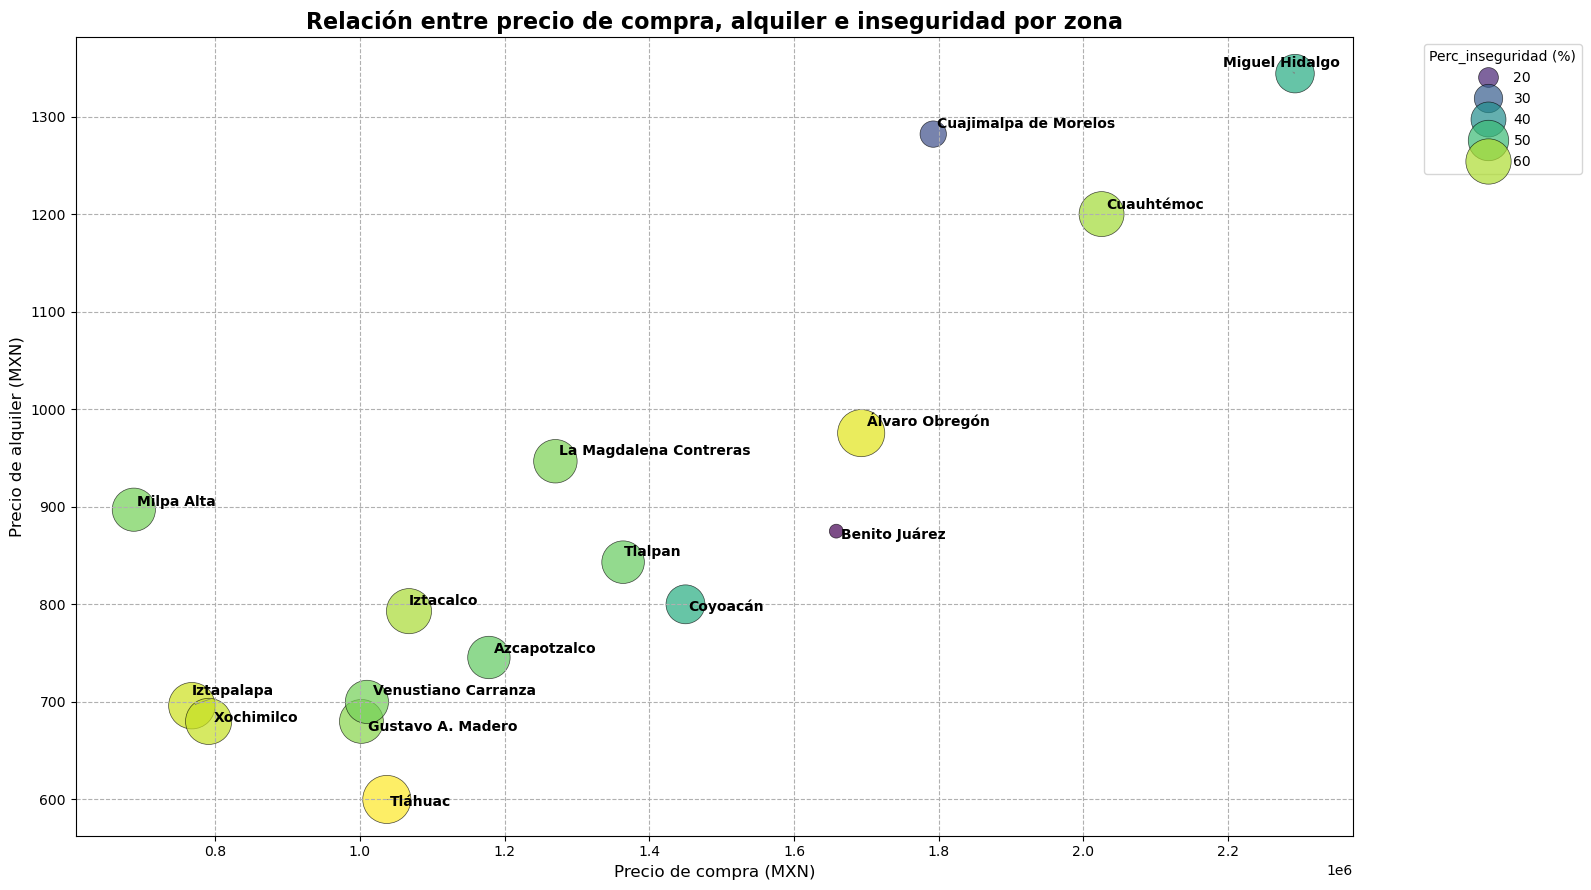

In [30]:
from adjustText import adjust_text

temp = df.groupby('alcaldia')[['precio_total','precio_compra','perc_in']].median()

plt.figure(figsize=(16, 9))
scatter = sns.scatterplot(
    data=temp,
    x='precio_compra',
    y='precio_total',
    hue='perc_in',
    size='perc_in',
    palette='viridis',
    sizes=(100, 1200),
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5
)

#Etiquetas
texts = []
for i in range(temp.shape[0]):
    texts.append(plt.text(
        temp.precio_compra.iloc[i],
        temp.precio_total.iloc[i],
        temp.index[i],
        fontsize=10,
        weight='bold'
    ))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

plt.title("Relación entre precio de compra, alquiler e inseguridad por zona", fontsize=16, weight='bold')
plt.xlabel("Precio de compra (MXN)", fontsize=12)
plt.ylabel("Precio de alquiler (MXN)", fontsize=12)

plt.grid(linestyle='--')

#Leyenda fuera del gráfico
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Perc_inseguridad (%)")

plt.tight_layout()
plt.show()

### Buscar inmuebles de cero habitaciones, cero a dos camas y que permitan alojar hasta tres huéspedes

* El número de habitaciones que presenta la mayor rentabilidad es de 0 al ofrecer mayor oportunidad de diversificar con un buen rendimiento relativo.

Exhibit 1.4.2

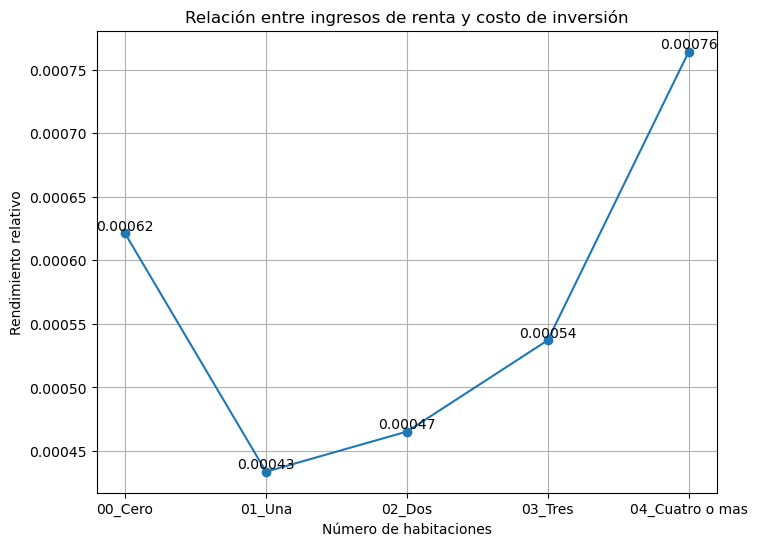

In [31]:
#Creamos un dataset provisional
df_ratio = minicubo_precio.loc['bedrooms_disc'].copy()

#Calculamos la relación renta / compra
df_ratio['rendimiento'] = df_ratio['precio_total'] / df_ratio['precio_compra']

#Graficando 
f, ax = plt.subplots(figsize=(8,6))

ax.plot(df_ratio.index, df_ratio['rendimiento'], marker='o')

ax.grid(True)
ax.set_title('Relación entre ingresos de renta y costo de inversión')
ax.set_xlabel('Número de habitaciones')
ax.set_ylabel('Rendimiento relativo')

#Agregando valores encima de los puntos
for i, val in enumerate(df_ratio['rendimiento']):
    ax.text(df_ratio.index[i], val, f"{val:.5f}", ha='center', va='bottom')

plt.show()

* Los inmuebles con 0 a 2 camas ofrecen la mejor oportunidad de crecimiento, porque requieren menos inversión y permiten comprar más unidades.

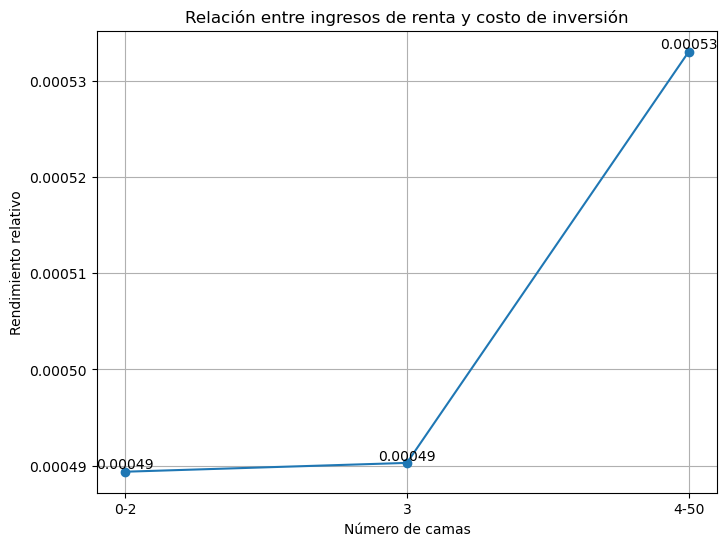

In [32]:
#Creando una variable para el rendimiento relativo en función del número de camas

#Dataset provisional
df_ratio = minicubo_precio.loc['beds_disc'].copy()

#Calculamos la relación renta / compra
df_ratio['rendimiento'] = df_ratio['precio_total'] / df_ratio['precio_compra']

#Graficando 
f, ax = plt.subplots(figsize=(8,6))

ax.plot(df_ratio.index, df_ratio['rendimiento'], marker='o')

ax.grid(True)
ax.set_title('Relación entre ingresos de renta y costo de inversión')
ax.set_xlabel('Número de camas')
ax.set_ylabel('Rendimiento relativo')

#Agregando valores encima de los puntos
for i, val in enumerate(df_ratio['rendimiento']):
    ax.text(df_ratio.index[i], val, f"{val:.5f}", ha='center', va='bottom')

plt.show()

* 1-3 huéspedes = menor riesgo y mayor liquidez

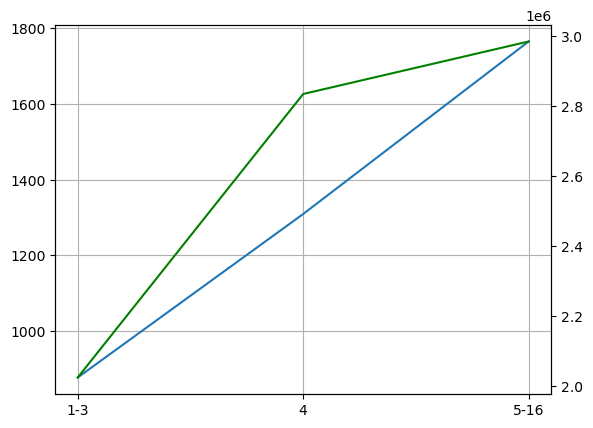

In [33]:
f, ax = plt.subplots()

ax.grid(True)
ax.plot(minicubo_precio.loc['accommodates_disc'].precio_total)
ax2 = ax.twinx()
ax2.plot(minicubo_precio.loc['accommodates_disc'].precio_compra,color = 'green');

* Esta configuración nos ofrece la mejor rentabilidad.

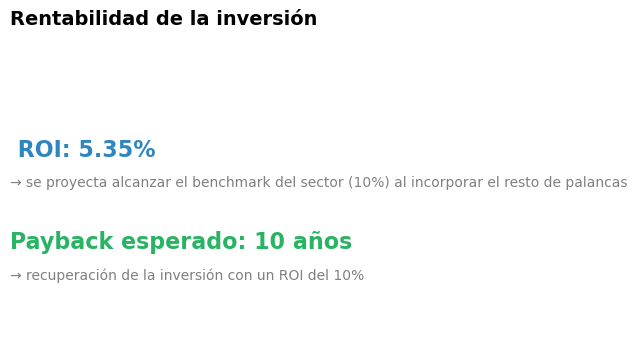

In [34]:
# Datos
roi = 0.0535  # 5.35%
payback = 10  # (proyectado al implementar el resto de palancas de rentabilidad)

# Crear figura
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis("off")  # quitamos ejes

# Título
plt.title("Rentabilidad de la inversión", fontsize=14, fontweight="bold", loc="left")

# Texto de ROI
ax.text(
    0, 0.6,
    f" ROI: {roi*100:.2f}%",
    fontsize=16, fontweight="bold", color="#2E86C1"
)
ax.text(
    0, 0.5,
    "→ se proyecta alcanzar el benchmark del sector (10%) al incorporar el resto de palancas",
    fontsize=10, color="gray"
)

# Texto de Payback
ax.text(
    0, 0.3,
    f"Payback esperado: {payback:.0f} años",
    fontsize=16, fontweight="bold", color="#28B463"
)
ax.text(
    0, 0.2,
    "→ recuperación de la inversión con un ROI del 10%",
    fontsize=10, color="gray"
)

plt.show()

### Buscar inmuebles que estando en uno de los barrios identificados no estén necesariamente cerca de puntos de interés

* Previsiblemente tendrán menor precio de compra
* Parece que la cercanía a puntos de interés no tiene un especial impacto sobre el precio de renta

Exhibit 1.4.3

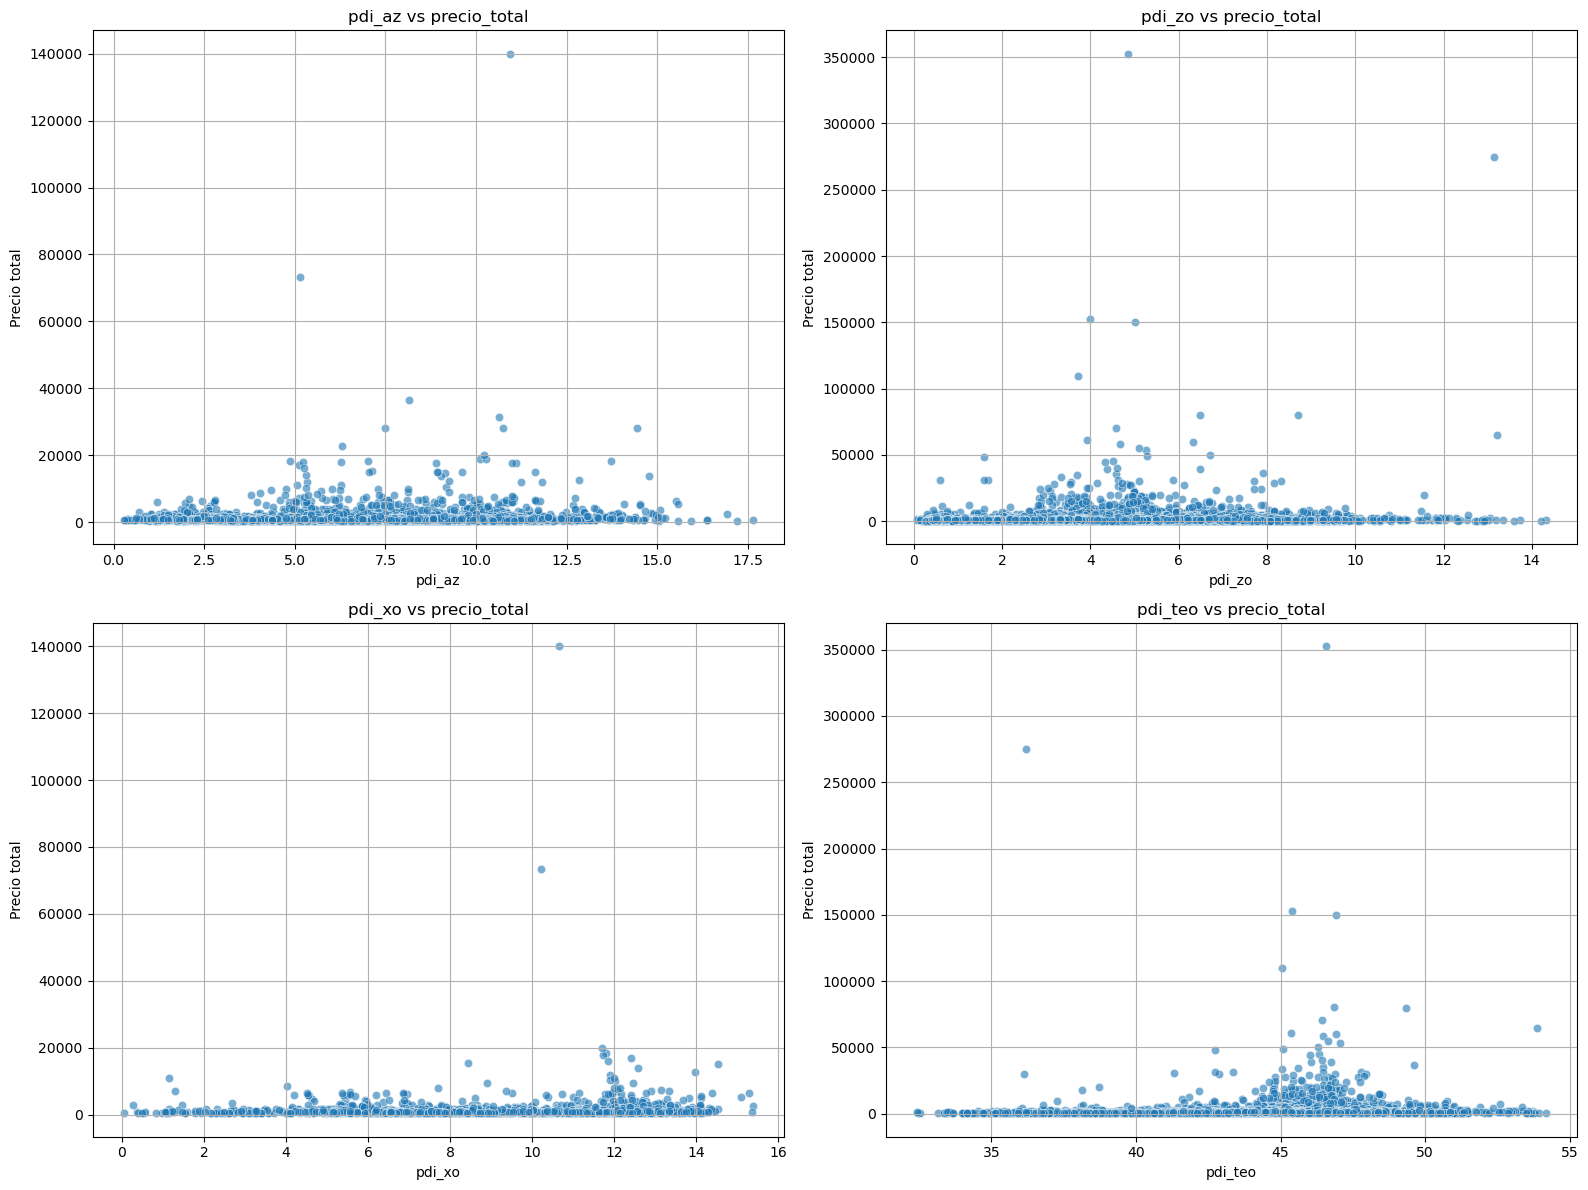

In [35]:
#Variables pdi con su respectiva selección de alcaldías
criterios = {
    "pdi_az": 7,
    "pdi_zo": 7,
    "pdi_xo": 5,
    "pdi_teo": 8
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (pdi, n) in enumerate(criterios.items()):
    # Selección específica para cada variable
    seleccion = df.groupby('alcaldia')[pdi].median().sort_values()[0:n].index.to_list()
    
    # Scatterplot
    sns.scatterplot(
        data=df.loc[df.alcaldia.isin(seleccion)],
        x=pdi,
        y="precio_total",
        ax=axes[i],
        alpha=0.6
    )
    
    axes[i].set_title(f"{pdi} vs precio_total")
    axes[i].set_xlabel(pdi)
    axes[i].set_ylabel("Precio total")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [36]:
import folium
import pandas as pd

# Filtrar las alcaldías
datos_m = df.loc[df['alcaldia'].isin(['Benito Juárez', 'La Magdalena Contreras'])].copy()

# Generamos los cortes dinámicamente
precio_disc = pd.qcut(
    datos_m['precio_compra'],
    q=[0, .25, .5, .75, 1.],
    duplicates='drop'   # elimina cortes repetidos
)

# Definimos una lista de colores posibles
colores = ['yellow', 'orange', 'blue', 'red']

# Asignamos sólo los colores que correspondan al número de categorías reales
datos_m['precio_compra_disc'] = precio_disc.cat.rename_categories(
    colores[:len(precio_disc.cat.categories)]
)

# Crear mapa centrado en CDMX
mapa = folium.Map(location=[19.4326018, -99.1332049], zoom_start=12)

# Dibujar círculos
for piso in range(len(datos_m)):
    folium.CircleMarker(
        location=[datos_m.iloc[piso]['latitude'], datos_m.iloc[piso]['longitude']],
        popup=f"Precio compra: {datos_m.iloc[piso]['precio_compra']}",
        fill=True,
        color=datos_m.iloc[piso]['precio_compra_disc'],
        fill_opacity=1,
        radius=5
    ).add_to(mapa)

mapa